_version log: seperated code into jupyter notebook cells_

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def detector_binning(x, bins, signal):
    numBins = len(bins)
    binEdges = np.linspace(np.min(bins), np.max(bins), numBins + 1)
    h, whichBin = np.histogram(x, binEdges) #here whichBin is the boundries of each bin
    whichBin = np.digitize(x, whichBin) #here whichBin relates every value in x to the index of the bin
    binMean = np.zeros(numBins)
    for i in range(numBins):
        flagBinMembers = (whichBin == i)
        binMembers = signal[flagBinMembers]
        binMean[i] = np.mean(binMembers)
    return binMean

def gaussian_line(x, x0g, dx):
    return np.exp(-(x - x0g) ** 2 / (2 * dx ** 2))

def single_sided_ft(x, Fs):
    N = x.shape[0]
    NFFT = 2 ** np.ceil(np.log2(N))
    X = np.fft.fft(x, int(NFFT)) / N
    f = Fs / 2 * np.linspace(0, 1, int(NFFT / 2 + 1))
    f = f[:, np.newaxis]
    X = 2 * np.abs(X[:int(NFFT / 2 + 1)])
    return X, f

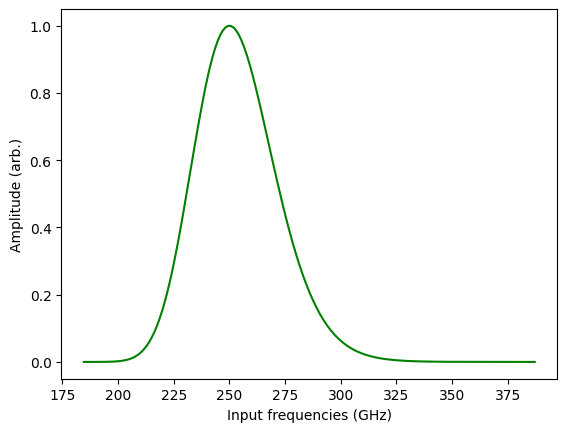

In [5]:
# Grid parameters
xmax = 5100 * 100
nx = 2 ** 15
theta = 4
line_centre_THz = 0.25
line_centre = (1.0 / line_centre_THz) * 299.792458
optic_dia = 26
sin_theta_incident = np.sin(theta * np.pi / 180)
freqpos_nograting = np.abs(2 * (1 / line_centre) * sin_theta_incident)
spacing = line_centre / (2 * sin_theta_incident)

# Detector parameters
pixelsize = 500
z0 = 0
number_of_points = 150
x0 = (pixelsize * number_of_points) / 2
x1 = -x0
Nwav = freqpos_nograting * (pixelsize * number_of_points)
pathdiff = Nwav * line_centre
ResPower = (pathdiff * 2) / line_centre

# Peak parameters
FWHM = 200

# Grids
x = np.linspace(-xmax, xmax, nx)
dxg = x[1] - x[0]
kx = np.linspace(-np.pi, np.pi, nx) / dxg

grat = 0
e0 = np.ones_like(x)
line_colour = 'g'

nl = 150
line_width = FWHM / 2.3548
lambda_val = line_centre + 0.5 * line_width * np.linspace(-10, 10, nl)
ii = lambda_val > 0
lambda_val = lambda_val[ii]
spec = gaussian_line(lambda_val, line_centre, line_width)

# Plot peak in MATLAB graph
lambdaGHz = (1.0 / (lambda_val / 299.7924)) * 1e3
plt.figure(2)
plt.plot(lambdaGHz, spec, line_colour)
plt.xlabel('Input frequencies (GHz)')
plt.ylabel('Amplitude (arb.)')

plt.show()

In [6]:
# Write peak to .txt file
B45 = np.vstack((lambdaGHz, spec)).T
np.savetxt('peaksinput.txt', B45, fmt='%6.9f', header='lambdaGHz spec')

C:\Users\syf83691\AppData\Local\Temp\ipykernel_8004\3012929730.py:27: RuntimeWarning: divide by zero encountered in divide
  um = 1.0 / um1


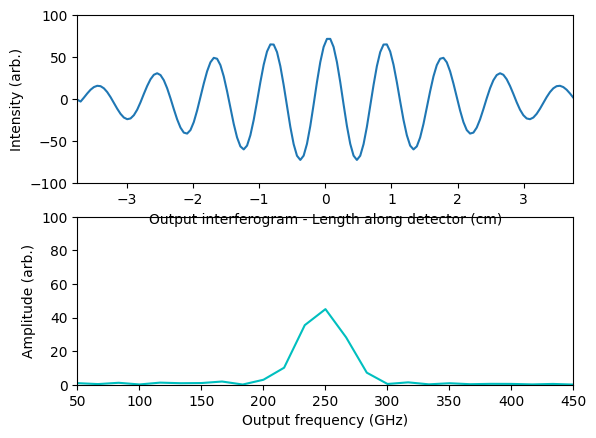

In [7]:
delay_x = 0 / sin_theta_incident
intensity = np.zeros(nx)
for i in range(nl - 40):
    k = 2 * np.pi / lambda_val[i]
    beam = e0 * np.exp(1j * k * sin_theta_incident * x)
    delayed_beam = e0 * np.exp(1j * k * sin_theta_incident * (x + delay_x))
    delayed_beam = np.flip(delayed_beam)
    e = beam + delayed_beam
    intensity += np.abs(e) ** 2 * spec[i]

# Detector
detector_points = np.linspace(x1, x0, number_of_points)
signal = detector_binning(x, detector_points, intensity)
signal = signal - np.mean(signal)

# Single-sided FT
dx = np.abs(detector_points[1] - detector_points[0])
spectrum, kd = single_sided_ft(signal, 1.0 / dx)
nyquist = np.max(kd) / 2

theta_max_nograting = np.arcsin((nyquist * line_centre) * 0.5) * (180 / np.pi)

um1 = kd / (2 * sin_theta_incident)
minwave = 1 / (nyquist / (2 * sin_theta_incident))
maxwave = 1 / (0.5e-4 / (2 * sin_theta_incident))

um = 1.0 / um1

# Plot output interferogram and frequency spectrum in a MATLAB graph
plt.figure(1)
GHz = (1.0 / um) * 299.792458 * 1e3

plt.subplot(2, 1, 2)
plt.plot(GHz, spectrum, 'c')
plt.axis([(line_centre_THz * 1000 - 200), (line_centre_THz * 1000 + 200), 0, 100])
plt.xlabel('Output frequency (GHz)')
plt.ylabel('Amplitude (arb.)')

plt.subplot(2, 1, 1)
plt.plot(detector_points * 1e-4, signal)
plt.axis([np.min(detector_points * 1e-4), np.max(detector_points * 1e-4), -100, 100])
plt.xlabel('Output interferogram - Length along detector (cm)')
plt.ylabel('Intensity (arb.)')

plt.show()

In [8]:
# Write output interferogram and frequency spectrum to .txt file
detector_pointswrite = detector_points[0] * 1e-4
signalwrite = signal[0]
B2 = np.vstack((detector_pointswrite, signalwrite)).T
np.savetxt('fft.txt', B2, fmt='%6.9f', header='kd spectrum')


B95 = np.vstack((GHz.flatten(), spectrum)).T
np.savetxt('outputwave.txt', B95, fmt='%6.9f', header='kd spectrum')